# Desk calculator project:

The task is to build quantum circuits that perform arithmetic operations between the binary reprentations of two positive integers.
The circuit must be implemented in Qiskit and demonstrated on a one or two instances.

## Toffoli

In [2]:
from qiskit import *

In [3]:
input1 = int(input("Enter a first positive integer between 0 and 15: "))
input2 = int(input("Enter a second positive integer between 0 and 15: "))

while (input1 < 0 or input1 > 15) or (input2 < 0 or input2 > 15):
    input1 = int(input("Enter a first positive integer between 0 and 15: "))
    input2 = int(input("Enter a second positive integer between 0 and 15: "))

first = '{0:{fill}3b}'.format(input1, fill='0')
second = '{0:{fill}3b}'.format(input2, fill='0')
print(first, second)


Enter a first positive integer between 0 and 15: 0
Enter a second positive integer between 0 and 15: 0
000 000


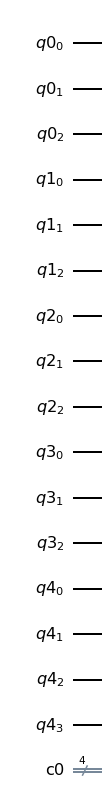

In [4]:
# Controlliamo quale numero è il più lungo e prendiamo quella lunghezza 'n' per dichiarare due quantumRegister che contengono 'n' qubit.
l = len(first)
l2 = len(second)
if l > l2:
     n = l
else:
     n = l2
        
# Inizializzazione dei registri; tre registri quantistici con n bit ciascuno
# 1 in più con n+1 bit, che conterrà la somma dei due #numeri
# L'ultimo q-register ha tre bit per memorizzare temporaneamente le informazioni
# Il registro classico ha n+1 bit, che serve per rendere leggibile la somma
a = QuantumRegister(n) #First number
b = QuantumRegister(n) #Second number
c = QuantumRegister(n) #Carry bits
supp = QuantumRegister(3) #support bit
ris = QuantumRegister(n+1) #Result bits
cl = ClassicalRegister(n+1) #Classical output

# Combinandoli tutti in un circuito quantistico
qc = QuantumCircuit(a, b, c, supp, ris, cl)
qc.draw('mpl') #library MatplotlibDraw packing "pylatexenc" for print (pip install pylatexenc in conda enviromentlist)

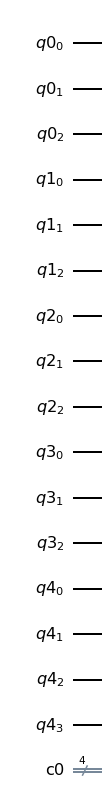

In [5]:
# Allestimento dei registri utilizzando i valori inseriti
# poiché i qubit inizialmente iniziano sempre da 0, usiamo not gate per impostare 1 i nostri qubit dove nel numero binario
# inserito c'è un 1
for i in range(l):
    if first[i] == "1":
        qc.x(a[l - (i+1)]) #Flip the qubit from 0 to 1
for i in range(l2):
    if second[i] == "1":
        qc.x(b[l2 - (i+1)]) #Flip the qubit from 0 to 1
qc.draw('mpl')

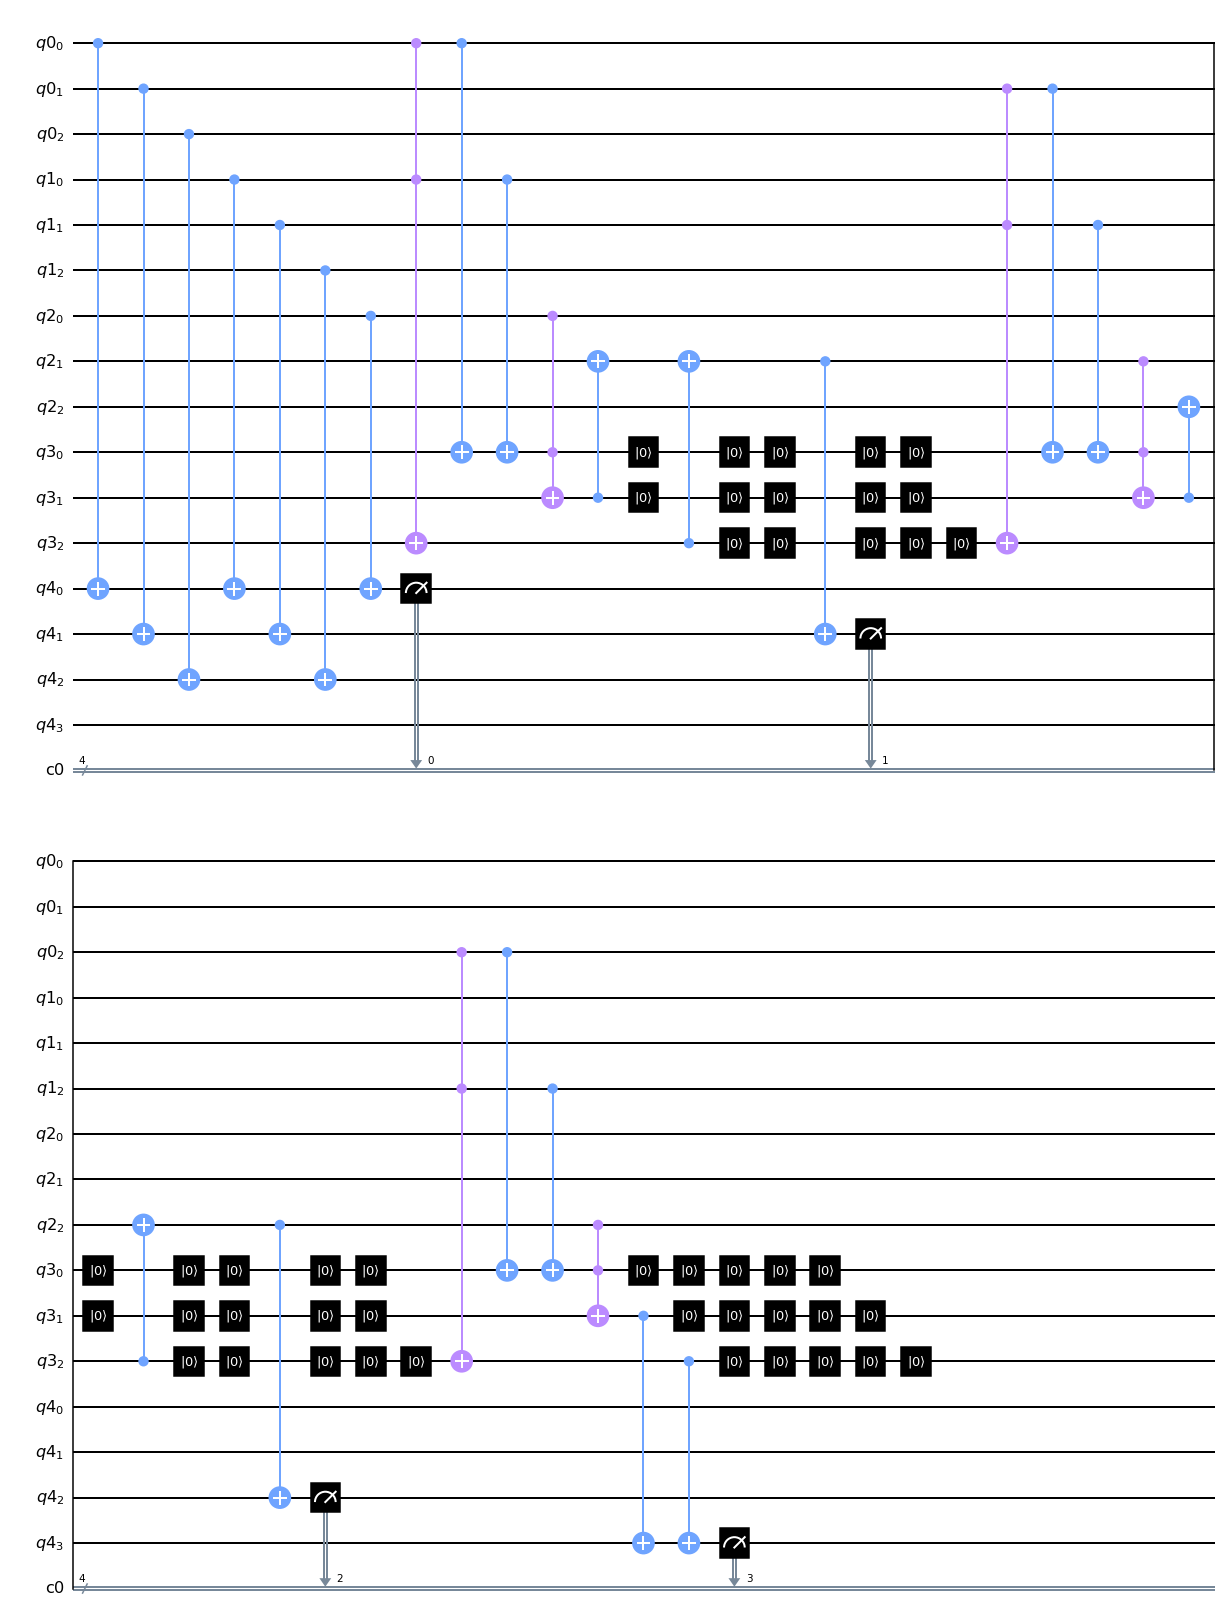

In [6]:
# Ripple Carry Adder
    
# sum = (a xor b) xor cin
# cout = (a e b) OR ((a xor b) e cin)
# Nota: invece di usare una porta OR possiamo usarne una XOR.
# Infatti i due AND, che sono gli input per l'OR, non possono mai essere entrambi uguali ad uno,
# quindi l'ultimo caso nella tavola di verità (A=1, B=1) di XOR e OR non si applica, rendendo XOR e OR uguali

for i in range(n-1):
    #SUM
    #sum = (a xor b) xor cin
    # use cnots to write the XOR of the inputs on qubit 2
    qc.cx(a[i], ris[i])
    qc.cx(b[i], ris[i])
    
    qc.cx(c[i], ris[i])

    #CARRY
    #cout = (a and b) XOR ((a xor b) and cin)
    #cout = i+1
    #cin = i
    # use ccx to write the AND of the inputs on qubit 3
    qc.ccx(a[i],b[i],supp[2])
    
    qc.cx(a[i], supp[0])
    qc.cx(b[i], supp[0])
    
    qc.ccx(supp[0], c[i], supp[1])
    
    qc.cx(supp[1], c[i+1])
    qc.cx(supp[2], c[i+1])  
    
    #reset to 0 supp
    qc.reset([9]*5)
    qc.reset([10]*5)
    qc.reset([11]*5)

#SUM
#sum = (a xor b) xor cin
qc.cx(a[n-1], ris[n-1])
qc.cx(b[n-1], ris[n-1])

qc.cx(c[n-1], ris[n-1])

#CARRY
#cout = (a and b) XOR ((a xor b) and cin)
#cout = i+1
#cin = i
# use ccx to write the AND of the inputs on qubit 3
qc.ccx(a[n-1],b[n-1],supp[2])

qc.cx(a[n-1], supp[0])
qc.cx(b[n-1], supp[0])

qc.ccx(supp[0], c[n-1], supp[1])

#nota: invece di salvare l'ultimo cout nel c qubit, lo memorizziamo nell'ultima cifra del risultato (quindi il ris più lungo + 1)
qc.cx(supp[1], ris[n])
qc.cx(supp[2], ris[n])  

#reset to 0 supp
qc.reset([9]*5)
qc.reset([10]*5)
qc.reset([11]*5)

    
for i in range(n+1):
    qc.measure(ris[i], cl[i])
    
qc.draw('mpl')

In [7]:
#Versione che utilizza il simulatore locale

#Imposta il backend scelto ed esegui il lavoro
#Set chosen backend and execute job
num_shots = 100 #Impostazione del numero di volte per ripetere la misurazione
job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=num_shots)
#Ottieni i risultati del programma
job_stats = job.result().get_counts()

In [8]:
print(job_stats) 

{'0000': 100}


In [9]:
#Versione che utilizza il simulatore remoto

IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_qasm_simulator')
counts = execute(qc, backend, shots=100).result().get_counts()
print(counts)

IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

# Addition with QFT

### Useful functions for all the operations

In [10]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


def executeQFT(qc, reg, n, pie):
     # Calcola la trasformata di Fourier quantistica di reg, un qubit alla volta
     # Applicare una porta Hadamard all'n-esimo qubit del registro quantistico reg, e
     # quindi applica rotazioni di fase ripetute con i parametri pi divisi per
     # potenze crescenti di due
    
    qc.h(reg[n])    
    for i in range(0, n):
        qc.cp(pie/float(2**(i+1)), reg[n-(i+1)], reg[n])    

def inverseQFT(qc, reg, n, pie):
     # Esegue la trasformata di Fourier quantistica inversa su un registro reg.
     # Applicare rotazioni di fase ripetute con i parametri pi divisi per
     # potenze decrescenti di due, quindi applicare una porta Hadamard all'ennesimo qubit
     # del registro reg.
    
    for i in range(n):
        qc.cp(-1*pie/float(2**(n-i)), reg[i], reg[n])
    qc.h(reg[n])
    
def initQubits(str, qc, reg, n):
# Capovolgere il qubit corrispondente nel registro se un bit nella stringa è un 1
    for i in range(n):
        if str[i] == "1":
            qc.x(reg[n-(i+1)])

def printResult(first, second, qc,result, cl, n, operator):

    # Misura i qubit
    for i in range(n+1):
        qc.measure(result[i], cl[i])

    # Eseguire utilizzando il simulatore locale
    print(bcolors.BOLD + bcolors.OKCYAN + 'Connecting to local simulator...' + bcolors.ENDC)
    # Imposta il backend scelto ed esegui il lavoro
    num_shots = 100 #Impostazione del numero di volte per ripetere la misurazione
    print(bcolors.BOLD + bcolors.OKCYAN + 'Connect!' + bcolors.ENDC)
    print(bcolors.BOLD + bcolors.OKCYAN + f'Running the experiment on {num_shots} shots...' + bcolors.ENDC)
    job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=num_shots)
    # Ottieni risultati del programma
    job_stats = job.result().get_counts()
    for key, value in job_stats.items():
        res = key
        prob = value
    print(bcolors.BOLD + bcolors.OKGREEN + f'\n{first} {operator} {second} = {res} with a probability of {prob}%' + bcolors.ENDC)

### QFT for addition

In [11]:
def evolveQFTStateSum(qc, reg_a, reg_b, n, pie):
     # Fa evolvere lo stato |F(ψ(reg_a))> in |F(ψ(reg_a+reg_b))> usando il quanto
     # Trasformata di Fourier condizionata sui qubit del reg_b.
     # Applicare rotazioni di fase ripetute con i parametri pi divisi per
     # potenze crescenti di due.
    l = len(reg_b)
    for i in range(n+1):
        if (n - i) > l - 1:
            pass
        else:
            qc.cp(pie/float(2**(i)), reg_b[n-i], reg_a[n])

In [12]:
import math
pie = math.pi

def sum(a, b, qc):
    
    n = len(a)-1
    # Calcola la trasformata di Fourier del registro a
    for i in range(n+1):
        executeQFT(qc, a, n-i, pie)
        
    # Somma i due numeri evolvendo la trasformata di Fourier F(ψ(reg_a))>
    # to |F(ψ(reg_a+reg_b))>
    for i in range(n+1):
        evolveQFTStateSum(qc, a, b, n-i, pie) 
        
    # Calcola la trasformata di Fourier inversa del registro a
    for i in range(n+1):
        inverseQFT(qc, a, i, pie)

### TEST

Enter a first positive integer between 0 and 2047:
1
Enter a second positive integer between 0 and 2047:
1
Connecting to local simulator...
Connect!
Running the experiment on 100 shots...

001 + 001 = 0010 with a probability of 100%


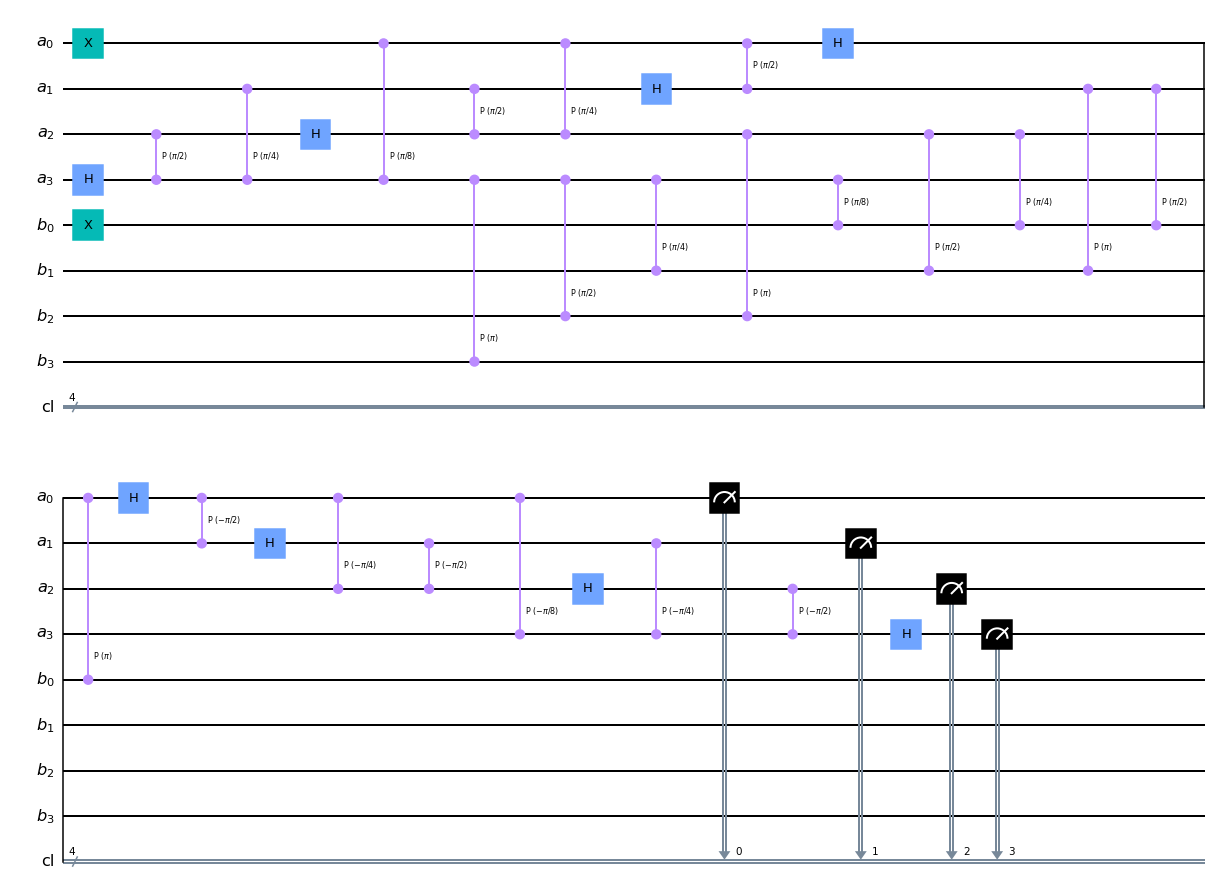

In [13]:
input1 = int(input(bcolors.WARNING + "Enter a first positive integer between 0 and 2047:\n" + bcolors.ENDC))
input2 = int(input(bcolors.WARNING + "Enter a second positive integer between 0 and 2047:\n" + bcolors.ENDC))


# check the inputs
while (input1 < 0 or input1 > 2047) or (input2 < 0 or input2 > 2047):
    if input1 < 0 or input1 > 2047:
        print(bcolors.FAIL + "Invalid first input number" + bcolors.ENDC)
        input1 = int(input(bcolors.WARNING + "Enter a first positive integer between 0 and 2047:\n" + bcolors.ENDC))

    if input2 < 0 or input2 > 2047:
        print(bcolors.FAIL + "Invalid second input number" + bcolors.ENDC)
        input2 = int(input(bcolors.WARNING + "Enter a second positive integer between 0 and 2047:\n" + bcolors.ENDC))


first = '{0:{fill}3b}'.format(input1, fill='0')
second = '{0:{fill}3b}'.format(input2, fill='0')


l1 = len(first)
l2 = len(second)

# Assicurarsi che 'primo' e 'secondo' siano della stessa lunghezza
# riempiendo la stringa più piccola con zeri

if l2>l1:
    first,second = second, first
    l2, l1 = l1, l2
second = ("0")*(l1-l2) + second
n = l1


# creare il registro in base all'operazione scelta
a = QuantumRegister(n+1, "a") 
b = QuantumRegister(n+1, "b")
accumulator = QuantumRegister(n+1, "accumulator")     
cl = ClassicalRegister(n+1, "cl")


  
qc = QuantumCircuit(a, b, cl, name="qc")
# Capovolgere il qubit corrispondente nel registro a se un bit nella stringa prima è un 1
initQubits(first, qc, a, n)
# Capovolgi il qubit corrispondente nel registro b se b bit nella stringa second è un 1
initQubits(second, qc, b, n)

sum(a,b,qc)
operator = '+'
printResult(first, second, qc,a, cl, n, operator)
qc.draw('mpl')

# Subtraction with QFT

In [14]:
def evolveQFTStateSub(qc, reg_a, reg_b, n, pie):
     # Fa evolvere lo stato |F(ψ(reg_a))> in |F(ψ(reg_a-reg_b))> usando il quanto
     # Trasformata di Fourier condizionata sui qubit del reg_b.
     # Applicare rotazioni di fase ripetute con i parametri pi divisi per
     # potenze crescenti di due.
    
    l = len(reg_b)
    for i in range(n+1):
        if (n - i) > l - 1:
            pass
        else:
            qc.cp(-1*pie/float(2**(i)), reg_b[n-i], reg_a[n])
            
pie = math.pi

def sub(a, b, qc):
    
    n = len(a) 

    #Calcola la trasformata di Fourier del registro a
    for i in range(0, n):
        executeQFT(qc, a, n-(i+1), pie)
    #Somma i due numeri evolvendo la trasformata di Fourier F(ψ(reg_a))>
    #to |F(ψ(reg_a-reg_b))>
    for i in range(0, n):
        evolveQFTStateSub(qc, a, b, n-(i+1), pie) 
    #Calcola la trasformata di Fourier inversa del registro a
    for i in range(0, n):
        inverseQFT(qc, a, i, pie)

### TEST

Enter a first positive integer between 0 and 2047:
12
Enter a second positive integer between 0 and 2047:
2
Connecting to local simulator...
Connect!
Running the experiment on 100 shots...

1100 - 0010 = 01010 with a probability of 100%


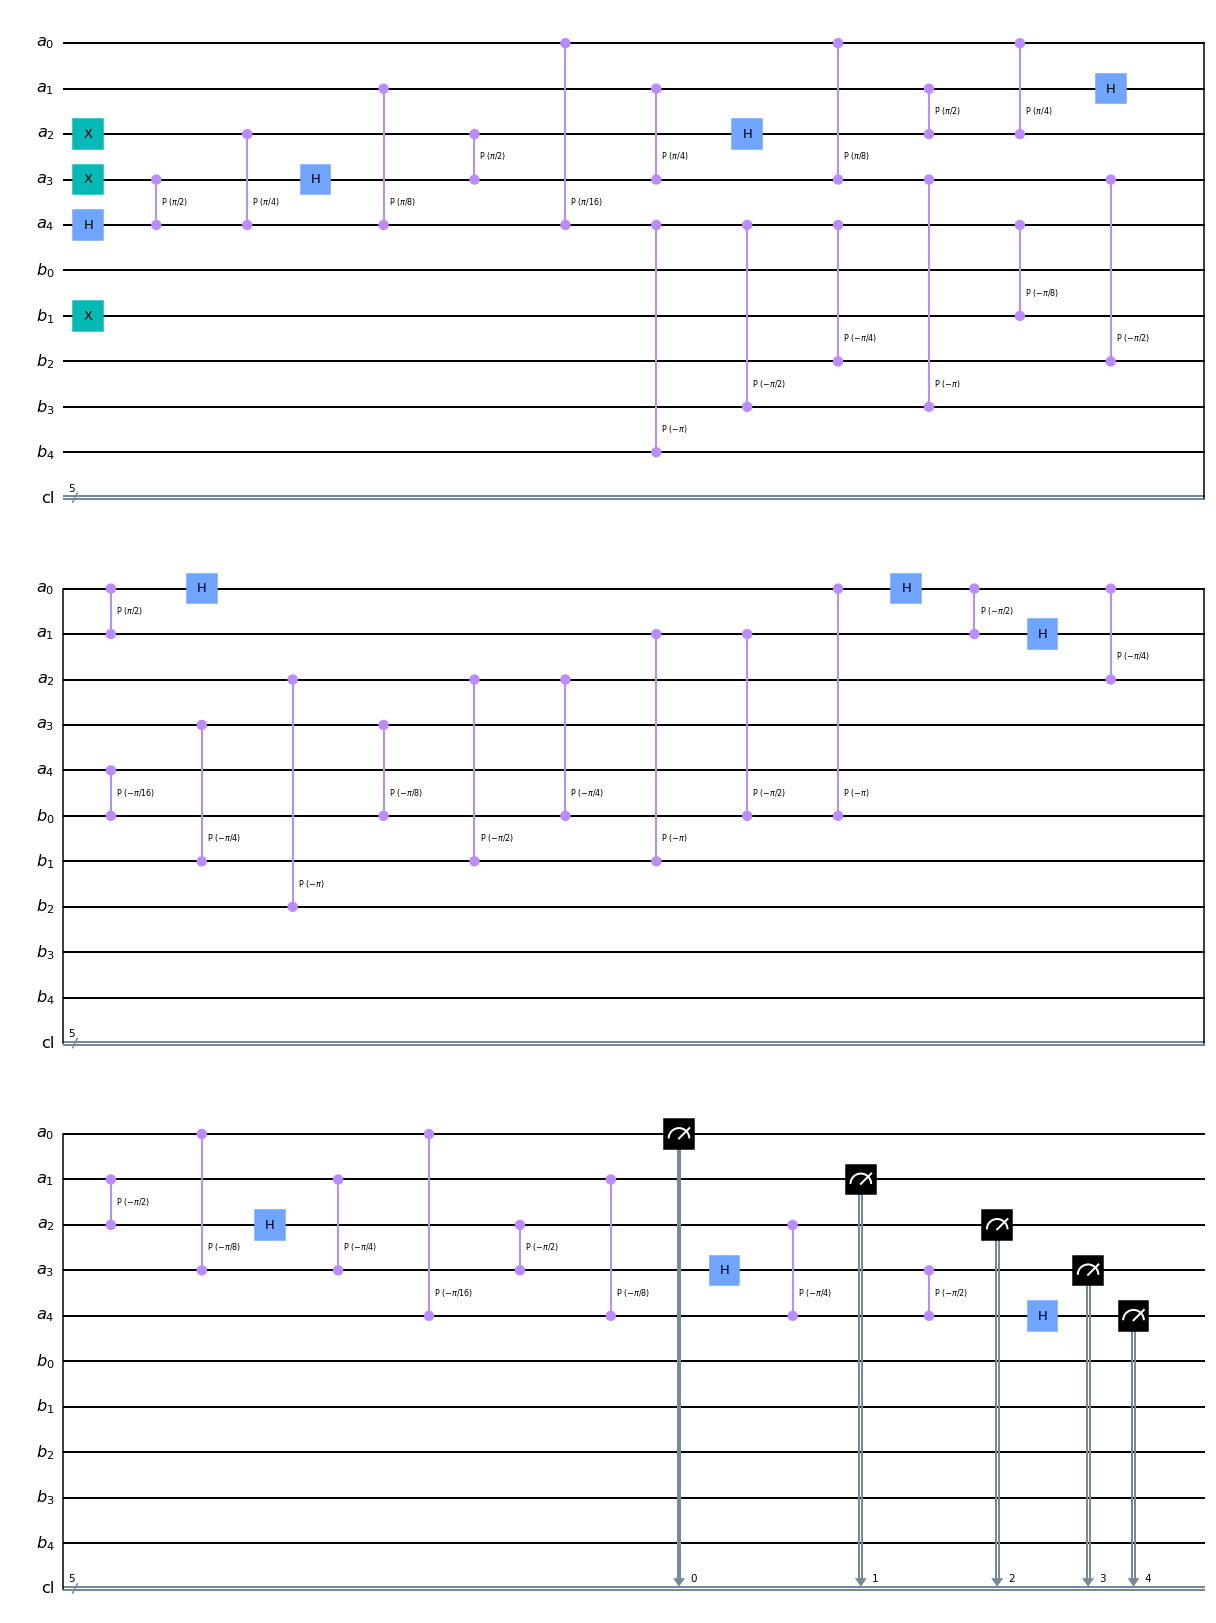

In [15]:
input1 = int(input(bcolors.WARNING + "Enter a first positive integer between 0 and 2047:\n" + bcolors.ENDC))
input2 = int(input(bcolors.WARNING + "Enter a second positive integer between 0 and 2047:\n" + bcolors.ENDC))


# check the inputs
while (input1 < 0 or input1 > 2047) or (input2 < 0 or input2 > 2047):
    if input1 < 0 or input1 > 2047:
        print(bcolors.FAIL + "Invalid first input number" + bcolors.ENDC)
        input1 = int(input(bcolors.WARNING + "Enter a first positive integer between 0 and 2047:\n" + bcolors.ENDC))

    if input2 < 0 or input2 > 2047:
        print(bcolors.FAIL + "Invalid second input number" + bcolors.ENDC)
        input2 = int(input(bcolors.WARNING + "Enter a second positive integer between 0 and 2047:\n" + bcolors.ENDC))


first = '{0:{fill}3b}'.format(input1, fill='0')
second = '{0:{fill}3b}'.format(input2, fill='0')


l1 = len(first)
l2 = len(second)

# Assicurarsi che 'primo' e 'secondo' siano della stessa lunghezza
# riempiendo la stringa più piccola con zeri

if l2>l1:
    first,second = second, first
    l2, l1 = l1, l2
second = ("0")*(l1-l2) + second
n = l1


# creare il registro in base all'operazione scelta
a = QuantumRegister(n+1, "a") 
b = QuantumRegister(n+1, "b")
accumulator = QuantumRegister(n+1, "accumulator")     
cl = ClassicalRegister(n+1, "cl")


  
qc = QuantumCircuit(a, b, cl, name="qc")
# Capovolgere il qubit corrispondente nel registro a se un bit nella stringa prima è un 1
initQubits(first, qc, a, n)
# Capovolgi il qubit corrispondente nel registro b se b bit nella stringa second è un 1
initQubits(second, qc, b, n)

sub(a,b,qc)
operator = '-'
printResult(first, second, qc,a, cl, n, operator)
qc.draw('mpl')

# Product with QFT


In [16]:
def multiply(a, secondDec, result, qc):
    
    n = len(a) -1
    # Calcola la trasformata di Fourier del registro 'risultato'
    for i in range(n+1):
        executeQFT(qc, result, n-i, pie)
    
     # Somma i due numeri evolvendo la trasformata di Fourier F(ψ(reg_a))>
     # a |F(ψ((second * reg_a))>, dove ripetiamo la somma tante volte quanto dice 'second',
     # facendo somme incrementali
    for j in range(secondDec):
        for i in range(n+1):
            evolveQFTStateSum(qc, result, a, n-i, pie)

    # Calcola la trasformata di Fourier inversa del registro a
    for i in range(n+1):
        inverseQFT(qc, result, i, pie)


### TEST

Enter a first positive integer between 0 and 2047:
1
Enter a second positive integer between 0 and 2047:
2
Connecting to local simulator...
Connect!
Running the experiment on 100 shots...

000001 * 010 = 0000010 with a probability of 100%


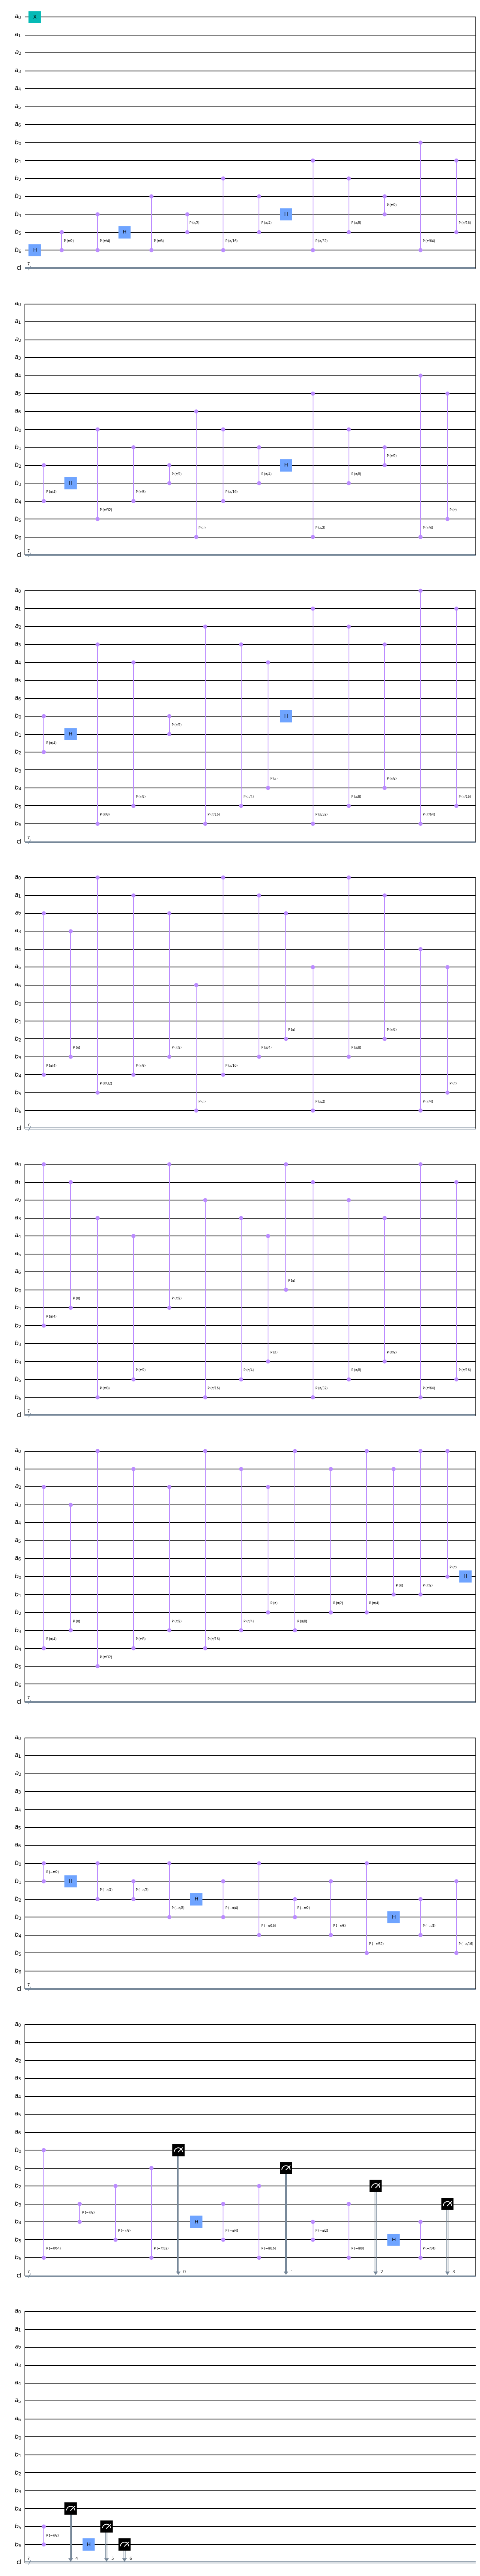

In [17]:
input1 = int(input(bcolors.WARNING + "Enter a first positive integer between 0 and 2047:\n" + bcolors.ENDC))
input2 = int(input(bcolors.WARNING + "Enter a second positive integer between 0 and 2047:\n" + bcolors.ENDC))


# check the inputs
while (input1 < 0 or input1 > 2047) or (input2 < 0 or input2 > 2047):
    if input1 < 0 or input1 > 2047:
        print(bcolors.FAIL + "Invalid first input number" + bcolors.ENDC)
        input1 = int(input(bcolors.WARNING + "Enter a first positive integer between 0 and 2047:\n" + bcolors.ENDC))

    if input2 < 0 or input2 > 2047:
        print(bcolors.FAIL + "Invalid second input number" + bcolors.ENDC)
        input2 = int(input(bcolors.WARNING + "Enter a second positive integer between 0 and 2047:\n" + bcolors.ENDC))


first = '{0:{fill}3b}'.format(input1, fill='0')
second = '{0:{fill}3b}'.format(input2, fill='0')
# for multiplication
firstDec = input1
secondDec = input2


l1 = len(first)
l2 = len(second)

# Padding 'first' della stessa lunghezza di 'result'
# poiché il risultato può avere al massimo i bit len(first) + lien(second) durante la moltiplicazione
first = ("0")*(l2) + first
n = l1+l2


# creare il registro in base all'operazione scelta
a = QuantumRegister(n+1, "a") 
b = QuantumRegister(n+1, "b")
accumulator = QuantumRegister(n+1, "accumulator")     
cl = ClassicalRegister(n+1, "cl")


  
qc = QuantumCircuit(a, b, cl, name="qc")
# Capovolgere il qubit corrispondente nel registro a se un bit nella stringa prima è un 1
initQubits(first, qc, a, n)

multiply(a,secondDec,b,qc)
operator = '*'
printResult(first, second, qc, b, cl, n, operator)
qc.draw('mpl')

# Division with QFT

In [18]:
def div(dividend, divisor, accumulator,c_dividend, circ, cl_index):
    d = QuantumRegister(1)
    circ.add_register(d)
    circ.x(d[0])

    c_dividend_str = '0'

    while c_dividend_str[0] == '0':
        sub(dividend, divisor, circ)
        sum(accumulator, d, circ)

        for i in range(len(dividend)):
            circ.measure(dividend[i], c_dividend[i])

        result = execute(circ, backend=Aer.get_backend('qasm_simulator'),
                         shots=10).result()
 
        counts = result.get_counts("qc")
        #print(counts)
        c_dividend_str = list(counts.keys())[0] #.split()[0]
     

    sub(accumulator, d, circ)

### TEST

Enter a first positive integer between 0 and 2047:
12
Enter a second positive integer between 0 and 2047:
2
Connecting to local simulator...
Connect!
Running the experiment on 100 shots...

1100 / 0010 = 00010 with a probability of 100%


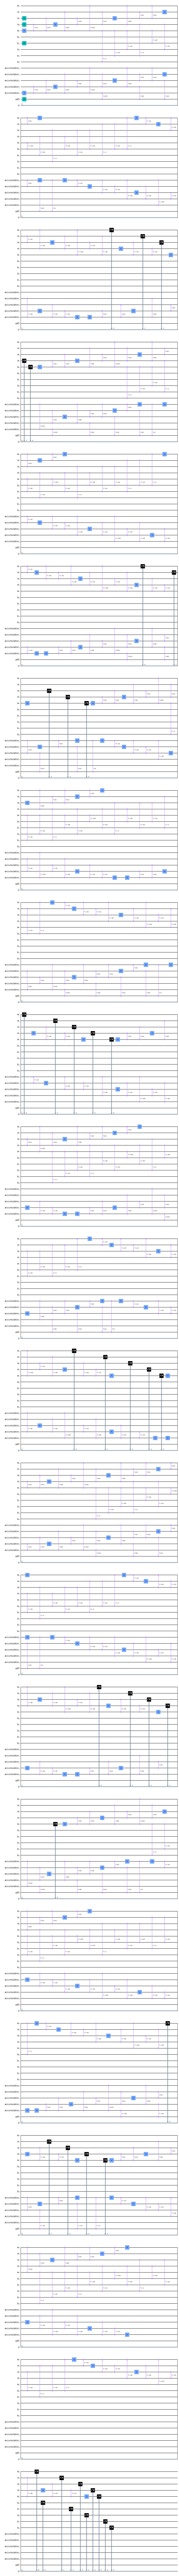

In [19]:
input1 = int(input(bcolors.WARNING + "Enter a first positive integer between 0 and 2047:\n" + bcolors.ENDC))
input2 = int(input(bcolors.WARNING + "Enter a second positive integer between 0 and 2047:\n" + bcolors.ENDC))


# check the inputs
while (input1 < 0 or input1 > 2047) or (input2 < 0 or input2 > 2047):
    if input1 < 0 or input1 > 2047:
        print(bcolors.FAIL + "Invalid first input number" + bcolors.ENDC)
        input1 = int(input(bcolors.WARNING + "Enter a first positive integer between 0 and 2047:\n" + bcolors.ENDC))

    if input2 < 0 or input2 > 2047:
        print(bcolors.FAIL + "Invalid second input number" + bcolors.ENDC)
        input2 = int(input(bcolors.WARNING + "Enter a second positive integer between 0 and 2047:\n" + bcolors.ENDC))


first = '{0:{fill}3b}'.format(input1, fill='0')
second = '{0:{fill}3b}'.format(input2, fill='0')
# for multiplication
firstDec = input1
secondDec = input2


l1 = len(first)
l2 = len(second)

if l2>l1:
    first,second = second, first
    l2, l1 = l1, l2
second = ("0")*(l1-l2) + second
n = l1


# creare il registro in base all'operazione scelta
a = QuantumRegister(n+1, "a") 
b = QuantumRegister(n+1, "b")
accumulator = QuantumRegister(n+1, "accumulator")     
cl = ClassicalRegister(n+1, "cl")


  
qc = QuantumCircuit(a, b, accumulator, cl, name="qc")
# Capovolgere il qubit corrispondente nel registro a se un bit nella stringa prima è un 1
initQubits(first, qc, a, n)
initQubits(second, qc, b, n)

div(a, b, accumulator, cl, qc, 0)
operator = '/'
printResult(first, second, qc, b, cl, n, operator)
qc.draw('mpl')